### Imports


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from torchvision.models import mobilenet_v3_small
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt

from src.dataset_loaders import ISAdetectDataset
from src.transforms import GrayScaleImage, RGBImage

### Setup


In [2]:
# Specify the model
MODEL = mobilenet_v3_small
TARGET_FEATURE = "wordsize"

# Model hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 1
LEARNING_RATE = 1e-4

# Specify which groups to use as validation set. Set to None to validate all groups.
VALIDATION_GROUPS = None
# VALIDATION_GROUPS = ["mips", "mipsel"]

# Set to an integer to limit the dataset size. Set to None to disable limit.
MAX_FILES_PER_ISA = None

### Helper functions


In [3]:
def get_device():
    """
    Returns 'cuda' if CUDA is available, else 'mps' if Apple Silicon GPU is available,
    otherwise 'cpu'.
    """
    device = None
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    print(f"Using device: {device}")
    return device

### Prepare


In [4]:
device = get_device()

dataset = ISAdetectDataset(
    dataset_path="../../dataset/ISAdetect/ISAdetect_full_dataset",
    transform=RGBImage(224, 224, num_channels=4),
    file_byte_read_limit=224 * 224 * 4,
    per_architecture_limit=MAX_FILES_PER_ISA,
)

groups = list(map(lambda x: x["architecture"], dataset.metadata))
target_feature = list(map(lambda x: x[TARGET_FEATURE], dataset.metadata))
print(f"groups: {set(groups)}")
print(f"features: {set(target_feature)}")

Using device: cuda
groups: {'s390', 'riscv64', 'm68k', 'armhf', 'i386', 'powerpcspe', 'mips', 'amd64', 'sparc', 'sh4', 'arm64', 's390x', 'hppa', 'mipsel', 'armel', 'ia64', 'sparc64', 'ppc64el', 'mips64el', 'powerpc', 'alpha', 'x32', 'ppc64'}
features: {32, 64}


### Train and evaluate


In [5]:
logo = LeaveOneGroupOut()
label_encoder = LabelEncoder()

fold = 1
accuracies = {}
losses_per_fold = []  # Will store losses for each fold
log_every_n_steps = 10

for train_idx, test_idx in logo.split(
    X=range(len(dataset)), y=target_feature, groups=groups
):
    group_left_out = groups[test_idx[0]]

    if VALIDATION_GROUPS != None and group_left_out not in VALIDATION_GROUPS:
        continue

    print(f"\n=== Fold {fold} – leaving out group '{group_left_out}' ===")
    fold += 1

    all_train_labels = [dataset.metadata[i][TARGET_FEATURE] for i in train_idx]
    label_encoder.fit(all_train_labels)

    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)

    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
    )
    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8
    )

    model = MODEL(num_classes=2, weights=None)
    out_channels = model.features[0][0].out_channels
    model.features[0][0] = nn.Conv2d(
        4, out_channels, kernel_size=3, stride=2, padding=1, bias=False
    )

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    current_fold_losses = []
    step_counter = 0
    # Train model
    for epoch in range(NUM_EPOCHS):
        model.train()
        print(f"Epoch {epoch+1}:")
        epoch_losses = []

        for images, labels in tqdm(train_loader):
            images = images.to(device)

            encoded_labels = torch.from_numpy(
                label_encoder.transform(labels[TARGET_FEATURE])
            ).to(device)

            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, encoded_labels)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if step_counter % log_every_n_steps == 0:
                current_fold_losses.append({"step": step_counter, "loss": loss.item()})
            step_counter += 1

        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")
        print(f"Epoch {epoch+1} Final Loss: {epoch_losses[-1]:.4f}")

        # Evaluate model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                encoded_labels = torch.from_numpy(
                    label_encoder.transform(labels[TARGET_FEATURE])
                ).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == encoded_labels).sum().item()
                total += encoded_labels.size(0)

        accuracy = correct / total
        print(f"Test Accuracy: {100*accuracy:.2f}%")

    accuracies[group_left_out] = accuracy
    losses_per_fold.append(
        {"fold": fold - 1, "group": group_left_out, "losses": current_fold_losses}
    )


=== Fold 1 – leaving out group 'alpha' ===
Epoch 1:


100%|██████████| 1445/1445 [00:53<00:00, 26.95it/s]

Epoch 1 Average Loss: 0.3534
Epoch 1 Final Loss: 0.1971


Test Accuracy: 12.49%

=== Fold 2 – leaving out group 'amd64' ===
Epoch 1:


100%|██████████| 1438/1438 [00:52<00:00, 27.46it/s]

Epoch 1 Average Loss: 0.3223
Epoch 1 Final Loss: 0.1745


Test Accuracy: 9.62%

=== Fold 3 – leaving out group 'arm64' ===
Epoch 1:


100%|██████████| 1450/1450 [00:54<00:00, 26.43it/s]

Epoch 1 Average Loss: 0.3633
Epoch 1 Final Loss: 0.2412


Test Accuracy: 7.23%

=== Fold 4 – leaving out group 'armel' ===
Epoch 1:


100%|██████████| 1444/1444 [00:54<00:00, 26.37it/s]

Epoch 1 Average Loss: 0.3720
Epoch 1 Final Loss: 0.5303


Test Accuracy: 6.20%

=== Fold 5 – leaving out group 'armhf' ===
Epoch 1:


100%|██████████| 1444/1444 [00:54<00:00, 26.69it/s]

Epoch 1 Average Loss: 0.3619
Epoch 1 Final Loss: 0.2591


Test Accuracy: 97.60%

=== Fold 6 – leaving out group 'hppa' ===
Epoch 1:


100%|██████████| 1431/1431 [00:53<00:00, 26.53it/s]

Epoch 1 Average Loss: 0.3844
Epoch 1 Final Loss: 0.1928


Test Accuracy: 95.01%

=== Fold 7 – leaving out group 'i386' ===
Epoch 1:


100%|██████████| 1427/1427 [00:54<00:00, 26.08it/s]

Epoch 1 Average Loss: 0.3666
Epoch 1 Final Loss: 0.3720


Test Accuracy: 49.68%

=== Fold 8 – leaving out group 'ia64' ===
Epoch 1:


100%|██████████| 1429/1429 [00:56<00:00, 25.10it/s]

Epoch 1 Average Loss: 0.3709
Epoch 1 Final Loss: 0.2912


Test Accuracy: 17.32%

=== Fold 9 – leaving out group 'm68k' ===
Epoch 1:


100%|██████████| 1438/1438 [00:55<00:00, 25.72it/s]

Epoch 1 Average Loss: 0.3954
Epoch 1 Final Loss: 0.2809


Test Accuracy: 98.23%

=== Fold 10 – leaving out group 'mips' ===
Epoch 1:


100%|██████████| 1451/1451 [00:56<00:00, 25.68it/s]

Epoch 1 Average Loss: 0.3820
Epoch 1 Final Loss: 0.1527


Test Accuracy: 95.62%

=== Fold 11 – leaving out group 'mips64el' ===
Epoch 1:


100%|██████████| 1439/1439 [00:56<00:00, 25.43it/s]

Epoch 1 Average Loss: 0.3231
Epoch 1 Final Loss: 0.2645


Test Accuracy: 1.81%

=== Fold 12 – leaving out group 'mipsel' ===
Epoch 1:


100%|██████████| 1448/1448 [00:56<00:00, 25.61it/s]

Epoch 1 Average Loss: 0.3253
Epoch 1 Final Loss: 0.4136


Test Accuracy: 9.54%

=== Fold 13 – leaving out group 'powerpc' ===
Epoch 1:


100%|██████████| 1450/1450 [00:56<00:00, 25.52it/s]

Epoch 1 Average Loss: 0.3623
Epoch 1 Final Loss: 0.2364


Test Accuracy: 98.40%

=== Fold 14 – leaving out group 'powerpcspe' ===
Epoch 1:


100%|██████████| 1445/1445 [00:56<00:00, 25.54it/s]

Epoch 1 Average Loss: 0.4074
Epoch 1 Final Loss: 0.4609


Test Accuracy: 86.37%

=== Fold 15 – leaving out group 'ppc64' ===
Epoch 1:


100%|██████████| 1462/1462 [00:57<00:00, 25.48it/s]

Epoch 1 Average Loss: 0.3252
Epoch 1 Final Loss: 0.1710


Test Accuracy: 4.20%

=== Fold 16 – leaving out group 'ppc64el' ===
Epoch 1:


100%|██████████| 1452/1452 [00:56<00:00, 25.58it/s]

Epoch 1 Average Loss: 0.3673
Epoch 1 Final Loss: 1.2134


Test Accuracy: 89.47%

=== Fold 17 – leaving out group 'riscv64' ===
Epoch 1:


100%|██████████| 1437/1437 [00:56<00:00, 25.63it/s]

Epoch 1 Average Loss: 0.3491
Epoch 1 Final Loss: 0.4674


Test Accuracy: 20.16%

=== Fold 18 – leaving out group 's390' ===
Epoch 1:


100%|██████████| 1426/1426 [00:56<00:00, 25.38it/s]

Epoch 1 Average Loss: 0.3796
Epoch 1 Final Loss: 0.1087


Test Accuracy: 3.41%

=== Fold 19 – leaving out group 's390x' ===
Epoch 1:


100%|██████████| 1451/1451 [00:56<00:00, 25.59it/s]

Epoch 1 Average Loss: 0.3781
Epoch 1 Final Loss: 0.2361


Test Accuracy: 49.29%

=== Fold 20 – leaving out group 'sh4' ===
Epoch 1:


100%|██████████| 1414/1414 [00:56<00:00, 25.18it/s]

Epoch 1 Average Loss: 0.3750
Epoch 1 Final Loss: 0.3980


Test Accuracy: 91.08%

=== Fold 21 – leaving out group 'sparc' ===
Epoch 1:


100%|██████████| 1429/1429 [00:56<00:00, 25.18it/s]

Epoch 1 Average Loss: 0.3382
Epoch 1 Final Loss: 0.1028


Test Accuracy: 4.00%

=== Fold 22 – leaving out group 'sparc64' ===
Epoch 1:


100%|██████████| 1455/1455 [00:57<00:00, 25.43it/s]

Epoch 1 Average Loss: 0.3143
Epoch 1 Final Loss: 0.1498


Test Accuracy: 0.52%

=== Fold 23 – leaving out group 'x32' ===
Epoch 1:


100%|██████████| 1441/1441 [00:56<00:00, 25.35it/s]

Epoch 1 Average Loss: 0.3826
Epoch 1 Final Loss: 0.3143


Test Accuracy: 37.86%


### Evaluate


In [6]:
print("Test accuracies for each fold/group:")
for group, acc in accuracies.items():
    print(f"{group}: {100*acc:.2f}%")


# Print overall performance across folds
mean_acc = np.mean(list(accuracies.values()))
std_acc = np.std(list(accuracies.values()))
print(f"\nAverage LOGO cross-validated test accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

Test accuracies for each fold/group:
alpha: 12.49%
amd64: 9.62%
arm64: 7.23%
armel: 6.20%
armhf: 97.60%
hppa: 95.01%
i386: 49.68%
ia64: 17.32%
m68k: 98.23%
mips: 95.62%
mips64el: 1.81%
mipsel: 9.54%
powerpc: 98.40%
powerpcspe: 86.37%
ppc64: 4.20%
ppc64el: 89.47%
riscv64: 20.16%
s390: 3.41%
s390x: 49.29%
sh4: 91.08%
sparc: 4.00%
sparc64: 0.52%
x32: 37.86%

Average LOGO cross-validated test accuracy: 0.4283 ± 0.3962


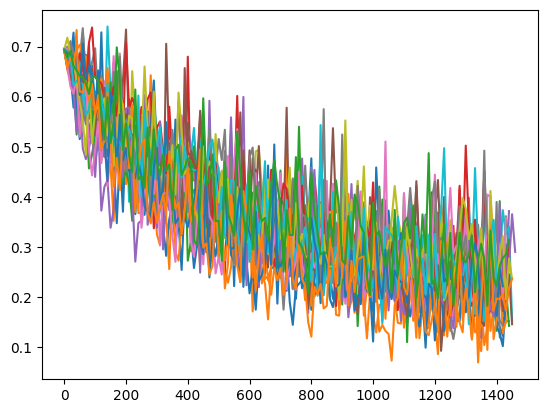

In [ ]:
# plot losses
for i, loss_data in enumerate(losses_per_fold):
    plt.plot(
        [x["step"] for x in loss_data["losses"]],
        [x["loss"] for x in loss_data["losses"]],
        label=f"Fold {loss_data['fold']} - {loss_data['group']}",
    )
    plt.show()